## The Original On-Policy Monte-Carlo Algorithm:
<img src="./images/on-policy_MC_control.PNG" width=1000 height=1000>

## An Incremental On-Policy Monte-Carlo Algorithm:
<img src="./images/on-policy_MC_control_edited.PNG" width=1000 height=1000>

In [1]:
import numpy as np

class OnPolicy_FirstVisit_MC_Agent:
    def __init__(self, n_states, n_actions, epsilon=1, final_epsilon_value=0.1, gamma=0.9, alpha=0.1):
        self.epsilon = epsilon
        self.final_epsilon_value = final_epsilon_value
        self.gamma = gamma
        self.alpha = alpha
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.all_actions = np.arange(n_actions)
        self.Q = np.zeros(shape=(n_states, n_actions))
        self.policy = self.init_epsilon_soft_policy(n_states, n_actions)
        
    def init_epsilon_soft_policy(self, n_states, n_actions):
        """
        The init_epsilon_soft_policy method initializes ε=1 which means the probability of each
        action is equal and uniformly distributed
        """
        policy = np.ones((n_states, n_actions), dtype=np.float32) / n_actions
        return policy
        
    def act(self, state):
        """
        The act method takes an action from the ε-soft policy
        """
        return np.random.choice(self.all_actions, p=self.policy[state, :])
    
    def act_epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.all_actions)
        else:
            action = self.act_greedy(state)
        return action
    
    def act_greedy(self, state):
        action = np.argmax(self.policy[state, :])
        return action
    
    def reset(self):
        self.states, self.actions, self.rewards = [], [], [0]  # Reward's index starts from 1
    
    def update(self, state, action, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        if done:
            self.epsilon_decay()
            G = 0
            visited = np.zeros((self.n_states, self.n_actions), dtype=np.int8)
            for t in reversed(range(len(self.states))):
                # TODO:
                G = self.gamma * G + self.rewards[t+1] # Compute G using γ (gamma) and reward in t+1 timestep
                s, a = self.states[t], self.actions[t] # Saving s[t] and a[t] in s and a for easier access
                if visited[s, a] == 0:
                    visited[s, a] += 1
                else:
                    continue
                    
                self.Q[s, a] = self.Q[s, a] + self.alpha * (G - self.Q[s, a])
                A_optimal = np.argmax(self.Q[s, :])
                self.policy[s,:] = self.epsilon / self.n_actions
                self.policy[s, A_optimal] = 1 - self.epsilon + self.epsilon / self.n_actions
    
    def epsilon_decay(self, factor=1e-4):
        if self.epsilon > self.final_epsilon_value:
            self.epsilon -= factor
        else:
            self.epsilon = self.final_epsilon_value

In [2]:
def display_status(episode, return_episode, epsilon, stime, returns, avg_returns, policy):
    """
    A helper function for displaying agent's behavior
    """
    clear_output(wait=True)
    etime = time()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    axes[0].set_title("Episode:" + str(episode) + " - Return:"+str(return_episode)\
              + " - Epsilon:" + str(epsilon)[:4] + " - elapsed time: " + str(etime - stime)[:4])
    axes[0].plot(list(range(len(returns))),returns)
    axes[0].plot(list(range(len(returns))),avg_returns, linewidth=3)
    axes[0].legend(["Returns", "Average Returns"])

    axes[1].imshow((10 * policy).reshape(30, 100))
    axes[1].set_title("A representation of agent's policy")
    axes[1].legend(["0"])
    axes[1].axis("off")
    plt.show()

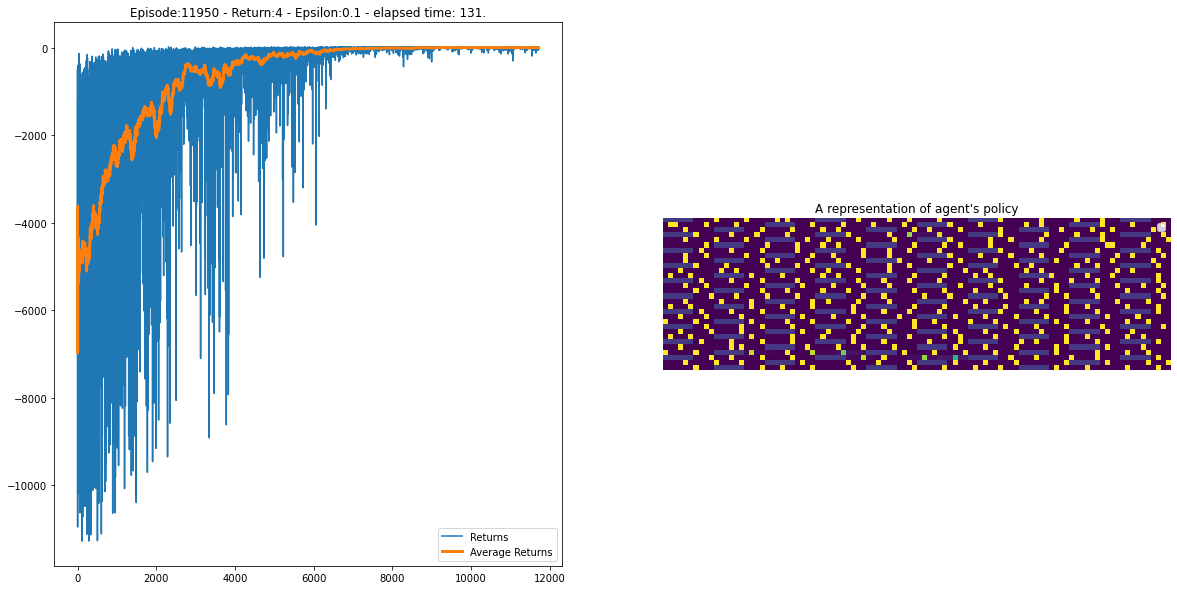

In [3]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = gym.make("Taxi-v3").env
agent = OnPolicy_FirstVisit_MC_Agent(n_states=env.observation_space.n, n_actions=env.action_space.n, final_epsilon_value=0.1)
EPISODES = 12000
STEPS = 3000
DISPLAY_RESULTS_INTERVAL = 50

returns = []
avg_returns = []
stime = time()
for episode in range(EPISODES):
    state = env.reset()
    agent.reset()
    done = False
    
    return_episode = 0
    for step in range(STEPS):
        action = agent.act_epsilon_greedy(state)
        state_, reward, done, info = env.step(action)
        agent.update(state, action ,reward, done)
        state = state_
        return_episode += reward
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns.append(avg)
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                display_status(episode, return_episode, agent.epsilon, stime, returns, avg_returns, agent.policy)
            break

In [4]:
# Let's checkout the last 10 returns
returns[-10:]

[-92, -2, 7, -26, -7, -1, 12, 2, 11, -8]

In [7]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

env = gym.make("Taxi-v3").env
# agent = MC_Agent(n_states=env.observation_space.n, n_actions=env.action_space.n)

for episode in range(5):
    state = env.reset()
    agent.reset()
    done = False

    return_episode = 0
    while not done: # for step in range(1000):
        env.render()
        action = agent.act_epsilon_greedy(state)
        state_, reward, done, _ = env.step(action)
        return_episode += reward
        state = state_
        clear_output(wait=True)
        sleep(0.2)
    print(return_episode)

7


<hr>

In [22]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = gym.make("FrozenLake8x8-v0", is_slippery=False).env
agent = OnPolicy_FirstVisit_MC_Agent(n_states=env.observation_space.n, n_actions=env.action_space.n, final_epsilon_value=0.01)
EPISODES = 20000
STEPS = 3000
DISPLAY_RESULTS_INTERVAL = 50

returns = []
avg_returns = []
stime = time()
for episode in range(EPISODES):
    state = env.reset()
    agent.reset()
    done = False
    
    return_episode = 0
    for step in range(STEPS):
        action = agent.act_greedy(state)
        state_, reward, done, info = env.step(action)
        agent.update(state, action ,reward, done)
        state = state_
        return_episode += reward
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns.append(avg)
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                clear_output(wait=True)
                etime = time()
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
                axes[0].set_title("Episode:" + str(episode) + " - Return:"+str(return_episode)\
                          + " - Epsilon:" + str(agent.epsilon)[:4] + " - elapsed time: " + str(etime - stime)[:4])
                axes[0].plot(list(range(len(returns))),returns)
                axes[0].plot(list(range(len(returns))),avg_returns, linewidth=3)
                axes[0].legend(["Returns", "Average Returns"])
                
                axes[1].imshow((10 * agent.policy).reshape(16, 16))
                axes[1].set_title("A representation of agent's policy")
                axes[1].legend(["0"])
                axes[1].axis("off")
                plt.show()
            break

KeyboardInterrupt: 

In [92]:
sum(returns[-100:])

78.0

In [95]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

env = gym.make("FrozenLake8x8-v0", is_slippery=False).env
# agent = MC_Agent(n_states=env.observation_space.n, n_actions=env.action_space.n)

for episode in range(3):
    state = env.reset()
    agent.reset()
    done = False

    return_episode = 0
    while not done: # for step in range(1000):
        env.render()
        action = agent.act_greedy(state)
        state_, reward, done, _ = env.step(action)
        return_episode += reward
        state = state_
        clear_output(wait=True)
        sleep(0.2)
    print(return_episode)
    sleep(3)

1.0


In [26]:
from environment import Racetrack
from constants import RACETRACK_1

In [28]:
track = Racetrack(constants.RACETRACK_1)

NameError: name 'constants' is not defined

In [20]:
env.step(2)

AssertionError: 